<a href="https://colab.research.google.com/github/ANUPRIYAR/TimeSeriesForecasting/blob/main/TimeSeries_capacity_optmization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import adfuller
from xgboost import XGBRegressor

In [47]:
data = pd.read_csv('/content/chartdata.csv', sep=';')
data.head()

,Timestamp,swxservice-CPU Utilization % [AVG],swxservice-Memory Utilization % [AVG]
0,2020-09-25 00:00:00,53.72,28.88
1,2020-09-25 01:00:00,53.65,27.18
2,2020-09-25 02:00:00,54.01,28.11
3,2020-09-25 03:00:00,53.74,26.88
4,2020-09-25 04:00:00,54.06,26.12


In [48]:
cpu_util = data[['Timestamp', 'swxservice-CPU Utilization % [AVG]']]
cpu_util.head()

,Timestamp,swxservice-CPU Utilization % [AVG]
0,2020-09-25 00:00:00,53.72
1,2020-09-25 01:00:00,53.65
2,2020-09-25 02:00:00,54.01
3,2020-09-25 03:00:00,53.74
4,2020-09-25 04:00:00,54.06


In [49]:
cpu_util.columns = ['ts', 'cpu_util_avg']

In [50]:
cpu_util.head()

,ts,cpu_util_avg
0,2020-09-25 00:00:00,53.72
1,2020-09-25 01:00:00,53.65
2,2020-09-25 02:00:00,54.01
3,2020-09-25 03:00:00,53.74
4,2020-09-25 04:00:00,54.06


In [51]:
print(cpu_util.shape)
cpu_util.tail()

(4320, 2)


,ts,cpu_util_avg
4315,2021-03-23 19:00:00,51.98
4316,2021-03-23 20:00:00,52.02
4317,2021-03-23 21:00:00,52.55
4318,2021-03-23 22:00:00,53.29
4319,2021-03-23 23:00:00,53.68


In [52]:
# Grouping by on daily basis
cpu_util['ts'] = pd.to_datetime(cpu_util['ts'], format='%Y-%m-%d %H:%M:%S')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
cpu_util.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ts            4320 non-null   datetime64[ns]
 1   cpu_util_avg  4137 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 67.6 KB


In [54]:
# cpu_util.groupby('ts')['cpu_util_avg'].mean()

In [55]:
# cpu_util segratting into date time year
cpu_util['date'] = cpu_util.ts.dt.date
cpu_util['year'] = cpu_util.ts.dt.year
cpu_util['month'] = cpu_util.ts.dt.month
cpu_util['hour'] = cpu_util.ts.dt.hour

In [56]:
cpu_util.head()

,ts,cpu_util_avg,date,year,month,hour
0,2020-09-25 00:00:00,53.72,2020-09-25,2020,9,0
1,2020-09-25 01:00:00,53.65,2020-09-25,2020,9,1
2,2020-09-25 02:00:00,54.01,2020-09-25,2020,9,2
3,2020-09-25 03:00:00,53.74,2020-09-25,2020,9,3
4,2020-09-25 04:00:00,54.06,2020-09-25,2020,9,4


In [103]:
cpu_util_per_day = cpu_util.groupby('date', as_index=False)['cpu_util_avg'].mean()

In [90]:
cpu_util_per_day.head()

date
2020-09-25    53.929583
2020-09-26    54.189583
2020-09-27    54.151429
2020-09-28    54.316364
2020-09-29    54.582500
Name: cpu_util_avg, dtype: float64

In [104]:
ts = cpu_util_per_day.set_index('date')

In [106]:
cpu_util_per_day.head()

,date,cpu_util_avg
0,2020-09-25,53.929583
1,2020-09-26,54.189583
2,2020-09-27,54.151429
3,2020-09-28,54.316364
4,2020-09-29,54.582500


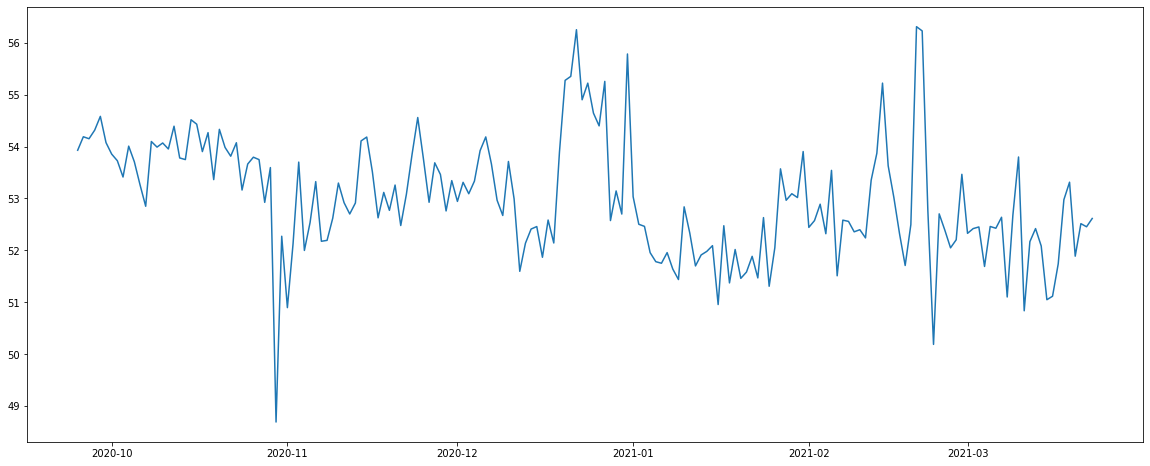

In [108]:
plt.figure(figsize=(20, 8))
plt.plot(ts)

In [61]:
def test_stationarity(ts):
   moving_avg = ts.rolling(7).mean()
   moving_std = ts.rolling(7).std()

   plt.figure(figsize=(12,8))
   plt.plot(moving_avg, label="Moving Average")
   plt.plot(moving_std, label="Moving std")
   plt.plot(ts, label="Time series")
   plt.legend()

  #  Check through Dickey fuller test
   result = adfuller(ts, autolag='AIC')
   dfout = pd.DataFrame(result[0:4], index=('Test statistics', 'p-value', '#Lags used', 'Number of observations'))
   print(dfout)
   for key, value in result[4].items():
      print('Critical value %s : %.5f'%(key, value))



                                 0
Test statistics          -5.462118
p-value                   0.000003
#Lags used                1.000000
Number of observations  178.000000
Critical value 1% : -3.46763
Critical value 5% : -2.87792
Critical value 10% : -2.57550


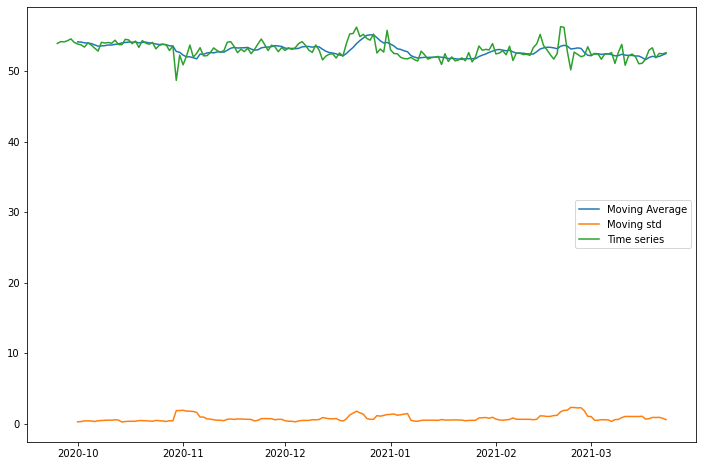

In [62]:
test_stationarity(cpu_util_per_day)

The data looks stationary

# **Modelling**

In [109]:
cpu_util_per_day.shape[0] * 0.85

153.0

In [112]:
train = cpu_util_per_day[:153]
test = cpu_util_per_day[153:]

In [118]:
train.columns = ['ds', 'y']
test.columns = ['ds', 'y']

In [119]:
train.head()

,ds,y
0,2020-09-25,53.929583
1,2020-09-26,54.189583
2,2020-09-27,54.151429
3,2020-09-28,54.316364
4,2020-09-29,54.582500


In [120]:
train.shape, test.shape

((153, 2), (27, 2))

In [116]:
from fbprophet import Prophet

In [117]:
model = Prophet()

In [121]:
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [122]:
future = model.make_future_dataframe(periods=27)
forecast = model.predict(future)

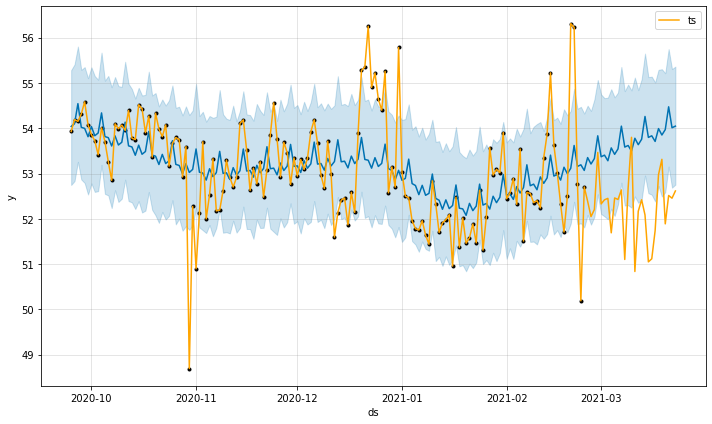

In [128]:
fig1 = model.plot(forecast)
plt.plot(ts, color='orange', label='ts')
plt.legend()

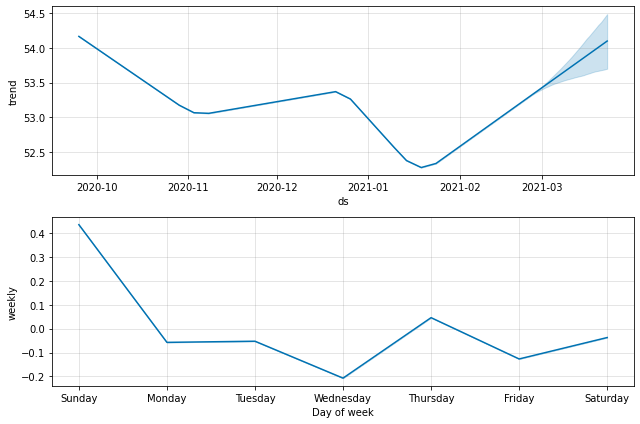

In [130]:
fig2 = model.plot_components(forecast)

In [138]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

# **To view Changepoints**

In [139]:
from fbprophet.plot import add_changepoints_to_plot

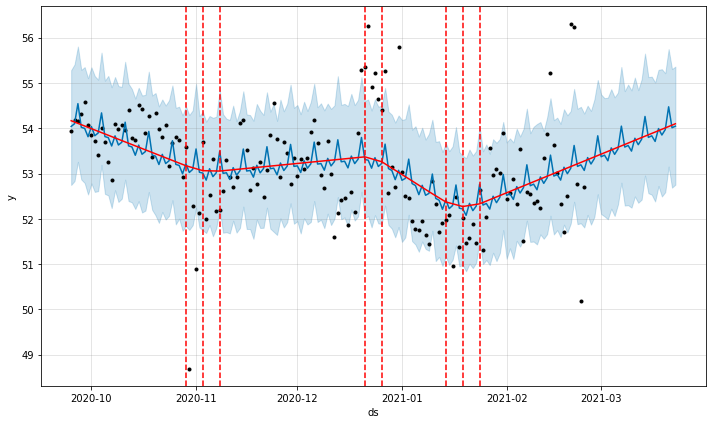

In [140]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the changepoint_range argument. For example, m = Prophet(changepoint_range=0.9) in Python 

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument **changepoint_prior_scale**. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


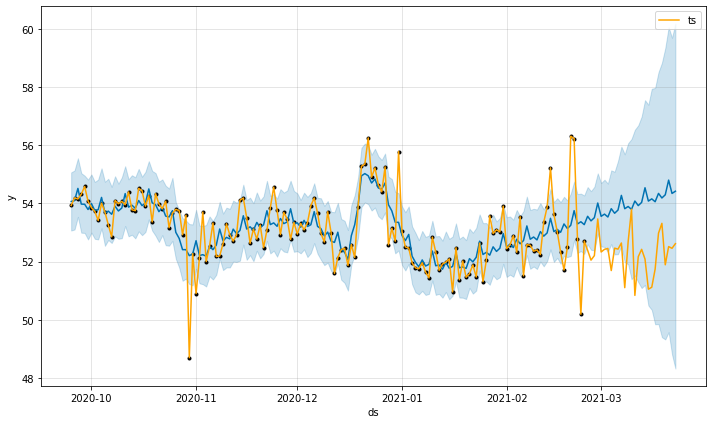

In [144]:
model = Prophet(changepoint_prior_scale=0.7)
forecast = model.fit(train).predict(future)
fig = model.plot(forecast)
plt.plot(ts, color='orange',label='ts')
plt.legend()

# **Daignostics**

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by **selecting cutoff points in the history**, and for each of them fitting the model using data only up to that cutoff point.

In [147]:
from fbprophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='70 days', period='27 days', horizon='30 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-12-29 00:00:00 and 2021-01-25 00:00:00


In [146]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-12-30,54.640168,53.698545,55.613130,52.700417,2020-12-29
1,2020-12-31,54.977225,54.022860,55.913558,55.784167,2020-12-29
2,2021-01-01,54.728182,53.748566,55.749092,53.035000,2020-12-29
3,2021-01-02,54.965643,53.994948,55.973015,52.503478,2020-12-29
4,2021-01-03,55.245368,54.148105,56.322881,52.463333,2020-12-29


In [148]:
df_p = performance_metrics(df_cv)

In [149]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.712016,1.646820,1.504714,0.028245,0.030336,0.333333
1,4 days,3.765429,1.940471,1.847946,0.034717,0.035519,0.166667
2,5 days,4.597150,2.144096,2.101039,0.039791,0.039075,0.000000
3,6 days,6.714605,2.591255,2.554768,0.048425,0.047649,0.000000
4,7 days,7.737527,2.781641,2.671209,0.050889,0.050715,0.000000


In [152]:
from fbprophet.plot import plot_cross_validation_metric

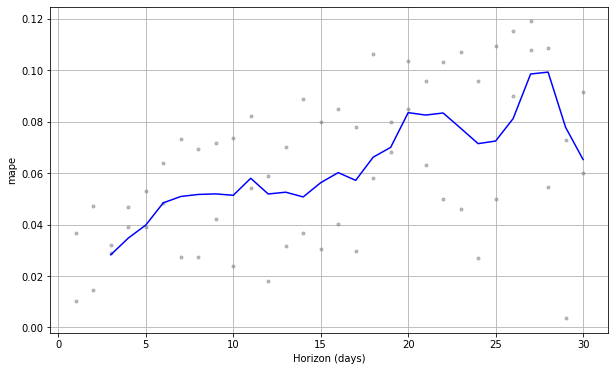

In [153]:
fig= plot_cross_validation_metric(df_cv, metric='mape')

# **Hyperparamter tuning**

In [155]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-12-26 00:00:00 and 2021-01-25 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe90d101050>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-12-26 00:00:00 and 2021-01-25 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe90d29c510>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  1.418135
1                     0.001                     0.10  1.413010
2                     0.001                     1.00  1.414220
3                     0.001                    10.00  1.413963
4                     0.010                     0.01  1.574031
5                     0.010                     0.10  1.574959
6                     0.010                     1.00  1.559869
7                     0.010                    10.00  1.571084
8                     0.100                     0.01  3.114657
9                     0.100                     0.10  3.095822
10                    0.100                     1.00  3.096000
11                    0.100                    10.00  3.116154
12                    0.500                     0.01  3.700136
13                    0.500                     0.10  3.707306
14                    0.500                     1.00  3

In [157]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


To add a regressor - > model.add_regressor('field_name')

eg:
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')